# 데이터 가져오기

In [ ]:
!pip install torchmetrics

# from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import torchmetrics
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import sleep

In [ ]:
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/ml-class-rhseung/data'
data_dir = './data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
train_data = pd.read_csv(f'{data_dir}/mnist_train.csv')
test_data = pd.read_csv(f'{data_dir}/mnist_test.csv')

train_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 데이터 전처리

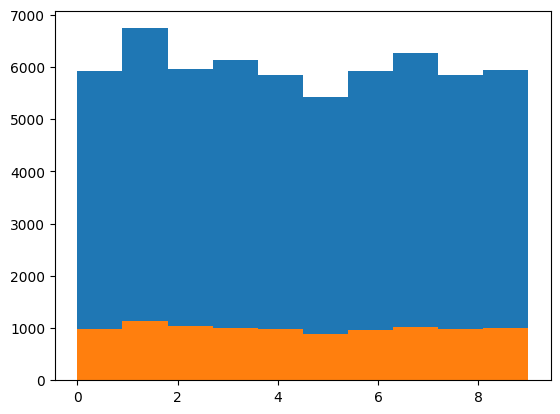

In [ ]:
plt.hist(train_data['label'])
plt.hist(test_data['label'])
plt.show()

In [ ]:
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 59.9 MB


# 데이터 확인하기

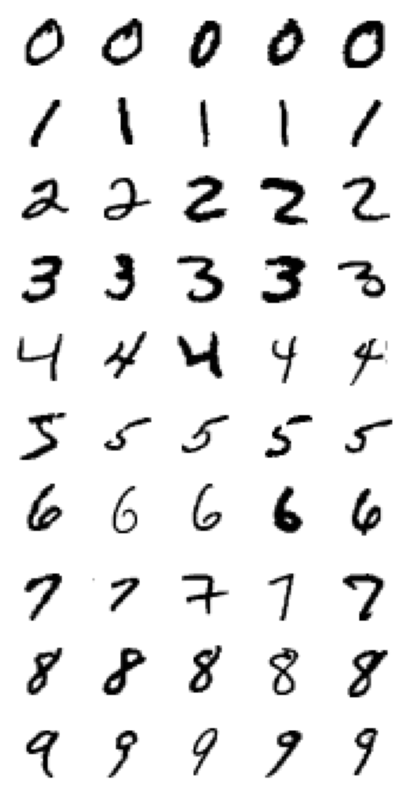

In [ ]:
output_classes = 10
image_width = image_height = 28

fig, ax = plt.subplots(output_classes, 5, figsize=(5, output_classes))

for i in range(ax.shape[0]):
    ith_label = train_data[train_data['label'] == i]

    for j in range(ax.shape[1]):
        ax[i, j].imshow(ith_label.iloc[j, 1:].to_numpy().reshape(image_width, image_height), cmap='gray_r')
        ax[i, j].axis('off')

# 데이터 정규화

In [ ]:
X = train_data.drop(columns=['label']).to_numpy().reshape(-1, 1, 28, 28) / 255
Y = train_data['label'].to_numpy()

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=224, shuffle=True, stratify=Y)

X_train.shape, X_valid.shape

((48000, 1, 28, 28), (12000, 1, 28, 28))

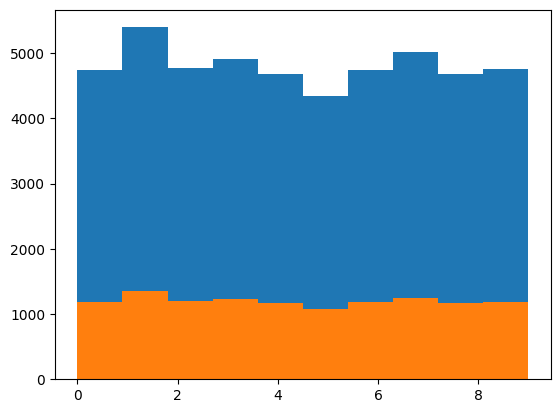

In [ ]:
plt.hist(Y_train)
plt.hist(Y_valid)
plt.show()

In [ ]:
X_test = test_data.drop(columns=['label']).to_numpy().reshape(-1, 1, 28, 28) / 255
Y_test = test_data['label'].to_numpy()

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, X_data: np.ndarray, Y_data: np.ndarray, device: torch.device = torch.device('cpu')):
        self.X = torch.FloatTensor(X_data).to(device)
        self.Y = torch.LongTensor(Y_data).to(device)

    def __getitem__(self, item):
        if not isinstance(item, int):
            raise TypeError

        return self.X[item], self.Y[item]

    def __len__(self):
        if len(self.X) != len(self.Y):
            raise ValueError

        return len(self.Y)

train_dset = MNISTDataset(X_train, Y_train, device=device)
valid_dset = MNISTDataset(X_valid, Y_valid, device=device)
test_dset = MNISTDataset(X_test, Y_test, device=device)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
list(map(lambda p: p.shape, next(iter(train_loader))))

[torch.Size([32, 1, 28, 28]), torch.Size([32])]

# 모델 구성 및 학습

In [ ]:
def model_maker():
    return nn.Sequential(
        # [batch 1 28 28] -> [batch 32 28 28]
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # [batch 32 28 28] -> [batch 32 14 14]
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [batch 32 14 14] -> [batch 64 14 14]
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # [batch 64 14 14] -> [batch 64 7 7]
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [batch 64 7 7] -> [batch 128 7 7]
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # [batch 128 7 7] -> [batch 128 6 6]
        nn.MaxPool2d(kernel_size=2, stride=1),

        # [batch 128 6 6] -> [batch 4608]
        nn.Flatten(1, 3),

        # [batch 4608] -> [batch 10]
        nn.Linear(4608, output_classes)
    ).to(device)

model = model_maker()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=output_classes).to(device)
cost = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(X[0].shape)
torchsummary.summary(model, X[0].shape)

(1, 28, 28)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                   [-1, 10]          46,090
Total params: 138,762
Trainable params: 138,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0

In [ ]:
epochs = 20

best_model_state = None
best_loss = inf
best_epoch = -1

for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as train:
        for x, y in train:
            train.set_description(f"Train (Epoch {epoch + 1:02d})")

            optimizer.zero_grad()
            predict = model(x)
            loss = cost(predict, y)
            loss.backward()
            optimizer.step()

            train.set_postfix(loss=loss.item())

    with tqdm(valid_loader, unit='batch') as valid:
        mean_loss = 0

        for x, y in valid:
            valid.set_description(f"Valid (Epoch {epoch + 1:02d})")

            with torch.no_grad():
                predict = model(x)
                acc = metric(predict, y)
                loss = cost(predict, y)
                mean_loss += loss.item() / len(valid)

            valid.set_postfix(loss=mean_loss, best_epoch=best_epoch + 1)

        if (not best_model_state) or mean_loss < best_loss:
            best_model_state = model.state_dict().copy()
            best_loss = mean_loss
            best_epoch = epoch

print(f"\n\nBest Epoch: {best_epoch + 1} [loss={best_loss}]")
torch.save(best_model_state, 'best_model.pth')

In [ ]:
best_model = model_maker()
best_model.load_state_dict(torch.load('best_model.pth'))

with torch.no_grad():
    output = best_model(test_dset.X)
    # Softmax를 취했으므로, 길이 10 배열에 각 확률이 들어있음

    predict = output.argmax(dim=1)    # 각 행에 대해 최댓값을 구하므로 =  = axis 1
    is_correct = test_dset.Y == predict

    print(f"Accuracy: {is_correct.float().mean()}")
    print(f"Correct: {is_correct.sum()}/{len(test_dset)}")

    wrong_indices = torch.where(is_correct == False)[0]
    row, col = len(wrong_indices) // 10, 10
    fig, ax = plt.subplots(row, col, figsize=(col / 2, row))
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            index = wrong_indices[i * col + j]

            ax[i, j].imshow(test_dset.X[index].cpu().numpy().reshape(28, 28), cmap='gray_r')
            ax[i, j].set_title(f"P={predict[index]}\nY={test_dset.Y[index]}")
            ax[i, j].axis('off')